This image is: <class 'numpy.ndarray'> with dimesions: (160, 320, 3)


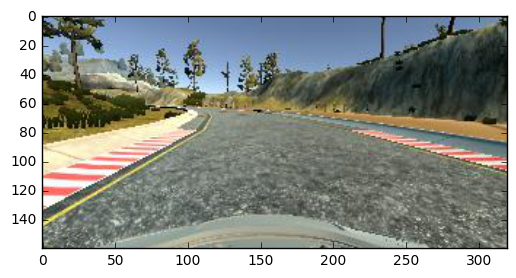

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

image = mpimg.imread("test.jpg")
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image) 

In [26]:
import math

m_size = 32  # the window for our moving average
left_mem = [] # our history of values for the left marker
right_mem = [] # our history of values for the right marker

def init():
    # i know, globals suck.
    # here we zero out our memory for the moving average caculation
    global m_size, left_mem, right_mem
    left_mem = []
    right_mem = []
    
def remember(left, right):
    # we store a new pair of left, right markers in our left, right memory.
    # we also clean up memory until we're back to the new "m_size" limit.
    print("Recording ", left, right)
    global m_size, left_mem, right_mem
    left_mem.append(left)
    right_mem.append(right)
    while len(left_mem) > m_size:
        left_mem = left_mem[1:]
        right_mem = right_mem[1:]
        
def sma(hist):
    # a simple moving average for (m,b) models for a lane marker
    return np.mean(hist, axis=0)

def process(img, overlay=False, scale=1.0):
    # here's the basic image pipeline for a single frame
    #
    # First, line up all our parameters
    #
    xsize = img.shape[1]*scale
    ysize = img.shape[0]*scale
    dx = int(xsize*0.0) # offset from x left, right border
    dy_top = int(ysize*0.35) # offset from y top border
    dy_bottom = int(ysize*0.2) #offset from y bottom 
    center = int(0.5*xsize) 
    vertices = np.array([[(dx,ysize-dy_bottom), 
                          (dx, dy_top), 
                          (xsize, dy_top), 
                          (xsize, ysize-dy_bottom)]], 
                        dtype=np.int32)
    kernel = 7  # gaussian blur kernel size
    lo_threshold = 100 #50 # low threshold for canny edge filter
    hi_threshold = 150 # high threshold for canny
    rho = 1 # grid increment for rho in rho, theta space 
    theta = np.pi/180 # grid increment for theta in rho, theta space
    threshold = 7 # number of items passing through a grid cell to be a line
    min_line_length = 8 # smallest line we'll accept
    max_line_gap = 3 # maximum distance between lines

    #
    # Now churn through the steps and return an image with overlays for markers
    #
    if not overlay:
        out = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        out = grayscale(out)
        out = region_of_interest(out, vertices)
        out = cv2.resize(out, (0,0), fx=0.5, fy=0.5)
        return out
    out = cv2.resize(img, (0,0), fx=scale, fy=scale)
    out = grayscale(out)
    out = gaussian_blur(out, kernel)
    out = canny(out, lo_threshold, hi_threshold)
    #return out
    out = region_of_interest(out, vertices)
    #return out
    out = hough_lines(out, rho, theta, threshold, min_line_length, max_line_gap)
    if not overlay:
        out = cv2.resize(out, (0,0), fx=0.5, fy=0.5)
        return grayscale(out)
    return weighted_img(out, img, a=0.8)


In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color  
    #print(vertices, ignore_mask_color)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_mean(vals):
    # weight the (m,b) of a line by its length in a set of line segments,
    # then return the weighted average for the set.
    d = 1.0/np.sum(x[2] for x in vals)
    m = d*np.sum(x[0]*x[2] for x in vals)
    b = d*np.sum(x[1]*x[2] for x in vals)
    return (m, b)

def is_left(slope,x1,x2,width):
    # A left marker will be 20' to 75' degrees 
    angle = (math.atan(slope)*180.0/math.pi)%360.0
    #print("Left check angle=", angle)
    return (angle > 20) and (angle < 75)

def is_right(slope,x1,x2,width):
    # A right marker will be 105' to 155' degrees and on the left of center
    angle = (math.atan(slope)*180.0/math.pi)%360.0
    #print("Right check angle=", angle)
    return (angle > 105) and (angle < 155)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    global left_mem, right_mem
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left = []
    right = []
    height = img.shape[0]
    width = img.shape[1]
    #
    # Separate little lines into left & right buckets
    #
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 != x2:
                m = (y2-y1)/(x1-x2)
                b = y2 - m*x2
                d = math.sqrt((y2-y1)**2 + (x2-x1)**2)
                if d > 2:
                    if is_left(m,x1,x2,width):
                        #print("Left!")
                        left.append((m,b,d))
                    elif is_right(m,x1,x2,width):
                        #print("Right!")
                        right.append((m,b,d))
                    #else:
                        #print("Rejecting",m,x1,x2,d)
    #
    # If we have buckets on both sides, add them to memory
    #
    if (len(left) > 0) and (len(right) > 0):
        #
        # Turn each bucket into a weighted average of the lines,
        # where lines vote by their length.
        #
        remember(weighted_mean(left),weighted_mean(right))
    
    #
    # Calculate our true lines through a simple moving average
    # of previous left and right line marker values.  This will
    # change less frequently and better characterize lanes as
    # we see shadows, poor markings, and what not. 
    #
    ys = img.shape[0]
    foo = [sma(left_mem), sma(right_mem)]
    #print("Foo is ", foo)
    if (len(left_mem) > 0) and (len(right_mem) > 0):
        for m, b in foo:
            y0 = ys
            x0 = int((y0-b)*1.0/m)
            y1 = int(ys*0.6)
            x1 = int((y1-b)*1.0/m)
            cv2.line(img, (x0, y0), (x1, y1), [255,0,0], 4)
        return 

    # Keep this around for debugging, showing us all the little red lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is not None:
        color_edges = np.dstack((lines, lines, lines)) 
        draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, b=1., g=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, g)

Image is  (80, 160)


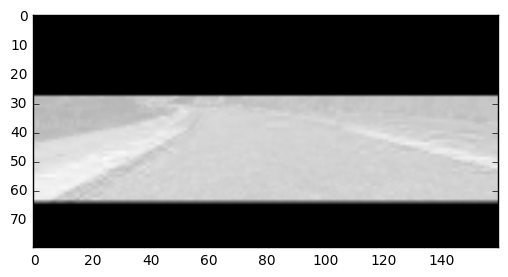

In [27]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

init()
base = "./"
for fig, f in [[0,"test.jpg"]]:
    init()
    plt.figure(fig)
    image = process(mpimg.imread(base+f).astype('uint8'), overlay=False)
    # We are resizing the image incorrectly - fix please!!
    print("Image is ", image.shape)
    #plt.imshow(process(image), cmap='gray')
    plt.imshow(image, cmap='gray')
    #plt.imshow(process(mpimg.imread(base+f).astype('uint8')))

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML
from glob import glob
import os.path

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return process(image, overlay=True)

def make_video(subdir):
    base = "./train/"+subdir+"/"
    out = base+subdir+".mp4"
    if not os.path.isfile(out):
        clip = ImageSequenceClip(base+"IMG", fps=20)
        clip.write_videofile(out, audio=False)
    return out

def process_video(subdir):
    base = "./train/"+subdir+"/"
    out = base+"lines.mp4"
    if not os.path.isfile(out):
        init()
        clip = VideoFileClip(base+subdir+".mp4")
        lines = clip.fl_image(process_image)
        lines.write_videofile(out, audio=False)
    return out

def make_all_videos():
    for d in [x[6:] for x in glob("train/*")]:
        make_video(d)
        process_video(d)

#make_all_videos()

In [29]:
import pandas as pd
import pickle

csv_keys = ['center','left','right','angle','throttle','brake','speed']

def normalize_image(image):
    img = np.array(image, dtype=np.float32)
    if len(image.shape) > 2:
        for i in range(0,3):
            lo = np.min(img[:,:,i])*1.0
            hi = np.max(img[:,:,i])*1.0
            img[:,:,i] = (img[:,:,i]-lo)/(hi-lo) - 0.5
    else:
        lo = np.min(img[:,:])*1.0
        hi = np.max(img[:,:])*1.0
        img[:,:] = (img[:,:]-lo)/(hi-lo) - 0.5
    return img

def image_to_data(subdir, path):
    path = "./train/"+subdir+"/"+(path.strip())
    data = normalize_image(process(mpimg.imread(path).astype('uint8'), overlay=False))
    return data

def gen_data(subdir):
    base = "./train/"+subdir+"/"
    csv = base+"driving_log.csv"
    data_path = base+"data.p"
    if not os.path.exists(data_path):
        df=pd.read_csv(csv, sep=',',header=None, names=csv_keys)
        X_raw = df[['left','center','right']]
        y_df = df[['angle']]
        X_df = X_raw.ix[:,:].apply(lambda row: row.apply(lambda path: image_to_data(subdir, path)),
                                   axis=1)
        X = np.array(X_df.values)
        y = np.array(y_df.values)[:,0]
        print("X size ", X.shape, "y shape", y.shape)
        pickle.dump([X,y], open(data_path, "wb"))
    return data_path 

def gen_all_data(verbose=True):
    for d in [x[6:] for x in glob("train/*")]:
        if verbose: 
            print("Generating data for "+d)
        with open(gen_data(d), mode='rb') as f:
            X,y = pickle.load(f)
            if verbose:
                print("  X is ", X.shape, " y is ",y.shape)
            
gen_all_data()

Generating data for left01
X size  (88, 3) y shape (88,)
  X is  (88, 3)  y is  (88,)
Generating data for left02
X size  (143, 3) y shape (143,)
  X is  (143, 3)  y is  (143,)
Generating data for left03
X size  (102, 3) y shape (102,)
  X is  (102, 3)  y is  (102,)
Generating data for left04
X size  (126, 3) y shape (126,)
  X is  (126, 3)  y is  (126,)
Generating data for left05
X size  (102, 3) y shape (102,)
  X is  (102, 3)  y is  (102,)
Generating data for normal
X size  (2084, 3) y shape (2084,)
  X is  (2084, 3)  y is  (2084,)
Generating data for normal2
X size  (7032, 3) y shape (7032,)
  X is  (7032, 3)  y is  (7032,)
Generating data for normal3
X size  (6525, 3) y shape (6525,)
  X is  (6525, 3)  y is  (6525,)
Generating data for normal4
X size  (5507, 3) y shape (5507,)
  X is  (5507, 3)  y is  (5507,)
Generating data for normal5
X size  (8553, 3) y shape (8553,)
  X is  (8553, 3)  y is  (8553,)
Generating data for right01
X size  (125, 3) y shape (125,)
  X is  (125, 3)  y 

In [47]:
# Reshape data into tensors for training

def load_all_data():
    X = np.array([])
    y = np.array([])
    for d in [x[6:] for x in glob("train/*")]:
        with open(gen_data(d), mode='rb') as f:
            X_d,y_d = pickle.load(f)
            for i in range(1,2):
                X = np.append(X,X_d[:,i])
                y = np.append(y,y_d)
    return X, y

def reshape_xy(X,y):
    image_shape = X[0].shape
    n_samples = len(X)
    X1 = np.zeros((n_samples, image_shape[0], image_shape[1], 1))
    y1 = np.zeros((n_samples))
    for i in range(0,n_samples):
        X1[i,:,:] = X[i].reshape(image_shape[0], image_shape[1], 1)
        y1[i] = y[i]
    return X1, y1

X,y = load_all_data()
print(X.shape, y.shape)

X1, y1 = reshape_xy(X,y)
print(X1.shape, y1.shape)

image_shape = X[0].shape
print(image_shape)



(30780,) (30780,)
(30780, 80, 160, 1) (30780,)
(80, 160)


In [71]:
# TODO: Build a two-layer feedforward neural network with Keras here.
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

# Recreate the NVidia experiment as a baseline, then iterate
n_samples = len(X)
model = Sequential()
model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2,2), input_shape=X1.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('relu'))
model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2,2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(2,2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

#n_samples = len(X)
#model = Sequential()
#model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2,2), input_shape=X1.shape[1:]))
#model.add(Activation('relu'))
#model.add(Flatten())
#model.add(Dense(100))
#model.add(Dense(1))
#model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_43 (Convolution2D) (None, 40, 80, 24)    624         convolution2d_input_11[0][0]     
____________________________________________________________________________________________________
activation_48 (Activation)       (None, 40, 80, 24)    0           convolution2d_43[0][0]           
____________________________________________________________________________________________________
convolution2d_44 (Convolution2D) (None, 20, 40, 36)    21636       activation_48[0][0]              
____________________________________________________________________________________________________
activation_49 (Activation)       (None, 20, 40, 36)    0           convolution2d_44[0][0]           
___________________________________________________________________________________________

In [57]:
# create test and train sets
from sklearn.model_selection import train_test_split

turns = np.where(y1 != 0)[0]
straight = np.where(y1 == 0)[0]
straight = straight[0:len(turns)/9]
straight = [0]
sample = np.append(turns,straight)
X2 = X1[sample]
y2 = y1[sample]

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

print("%d to train, %d to test" % (X_train.shape[0], X_test.shape[0]))

7721 to train, 1931 to test


In [69]:
# Compile our model

batch_size = 200
nb_epoch = 25

build_model = True
if build_model is True:
    model.compile(loss='mse', optimizer=Adam())
    build_model = False

history = model.fit(X_train, y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

Train on 7721 samples, validate on 1931 samples
Epoch 1/1
1800/7721 [=====>........................] - ETA: 26s - loss: 98.7811 

KeyboardInterrupt: 